In [26]:
import pandas as pd
import numpy as np
import math

In [27]:
file_path ="/content/drive/MyDrive/Delhivery project/A-n32-k5.vrp"

In [28]:
nodes = []
demands = []
depot = None

In [29]:
with open(file_path, 'r') as f:
    section = None
    for raw in f:
        line = raw.strip()
        if line == '' or line.startswith(('COMMENT','NAME','TYPE','DIMENSION','CAPACITY')):
            continue

        if line.startswith('NODE_COORD_SECTION'):
            section = 'NODE'
            continue

        if line.startswith('DEMAND_SECTION'):
            section = 'DEMAND'
            continue

        if line.startswith('DEPOT_SECTION'):
            section = 'DEPOT'
            continue

        if line == 'EOF':
            break

        if section == 'NODE':
            parts = line.split()
            if len(parts) >= 3:
                node_id = int(parts[0])
                x = float(parts[1])
                y = float(parts[2])
                nodes.append((node_id, x, y))

        elif section == 'DEMAND':
            parts = line.split()
            if len(parts) >= 2:
                node_id = int(parts[0])
                demand = float(parts[1])
                demands.append((node_id, demand))

        elif section == 'DEPOT':
            val = int(line.split()[0])
            if val != -1:
                depot = val

What to expect: Parsed: 32 nodes. Depot: 1 and heads of the tables.

In [30]:
# Create DataFrames
nodes_df = pd.DataFrame(nodes, columns=['node_id','x','y']).set_index('node_id')
demands_df = pd.DataFrame(demands, columns=['node_id','demand']).set_index('node_id')

In [31]:
# Distance matrix
coords = nodes_df[['x','y']].values
n = len(coords)
dist_matrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        dist_matrix[i][j] = round(math.hypot(coords[i][0]-coords[j][0],
                                            coords[i][1]-coords[j][1]), 3)

dist_df = pd.DataFrame(dist_matrix,
                       index=nodes_df.index,
                       columns=nodes_df.index)

nodes_df.head(), demands_df.head(), dist_df.iloc[:5,:5]

(            x     y
 node_id            
 1        82.0  76.0
 2        96.0  44.0
 3        50.0   5.0
 4        49.0   8.0
 5        13.0   7.0,
          demand
 node_id        
 1           0.0
 2          19.0
 3          21.0
 4           6.0
 5          19.0,
 node_id       1       2       3       4       5
 node_id                                        
 1         0.000  34.928  77.878  75.584  97.581
 2        34.928   0.000  60.308  59.203  90.874
 3        77.878  60.308   0.000   3.162  37.054
 4        75.584  59.203   3.162   0.000  36.014
 5        97.581  90.874  37.054  36.014   0.000)

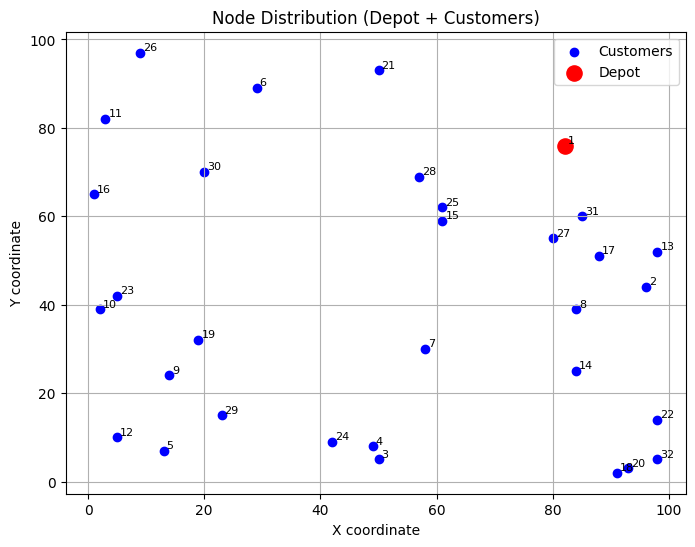

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# plot customer nodes
plt.scatter(nodes_df['x'], nodes_df['y'], c='blue', label='Customers')

# highlight depot
plt.scatter(nodes_df.loc[1, 'x'], nodes_df.loc[1, 'y'],
            c='red', s=120, label='Depot')

for node_id, row in nodes_df.iterrows():
    plt.text(row['x']+0.5, row['y']+0.5, str(node_id), fontsize=8)

plt.title("Node Distribution (Depot + Customers)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.grid(True)
plt.show()


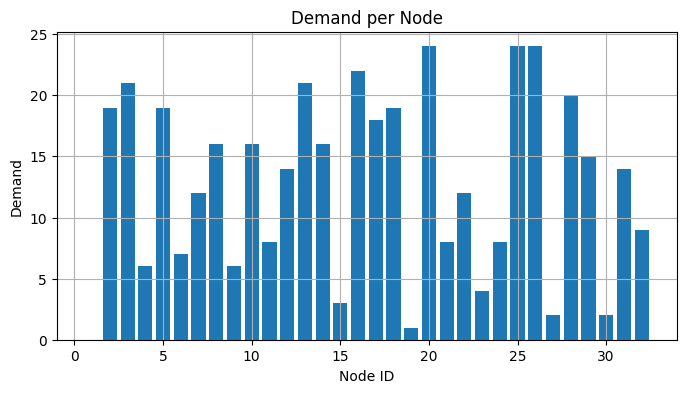

In [33]:
plt.figure(figsize=(8,4))
plt.bar(demands_df.index, demands_df['demand'])
plt.title("Demand per Node")
plt.xlabel("Node ID")
plt.ylabel("Demand")
plt.grid(True)
plt.show()


In [34]:
total_demand = demands_df['demand'].sum()
vehicle_capacity = 100
num_vehicles = 5

print("Total Demand:", total_demand)
print("Total Vehicle Capacity:", vehicle_capacity * num_vehicles)


Total Demand: 410.0
Total Vehicle Capacity: 500


**Interpretation:**

We have 410 total load to move.

Fleet capacity is 500, so the problem is feasible.

We do NOT need to increase fleet size.

We also have room for demand fluctuation.

**Business Insight:**
Delhivery can serve all nodes with the current 5-vehicle fleet. Utilization will be around 82% (410/500).
This is very good for a logistics network.

In [35]:
print("Min distance:", dist_df.values.min())
print("Max distance:", dist_df.values.max())
print("Average distance:", dist_df.values.mean())


Min distance: 0.0
Max distance: 128.004
Average distance: 56.900853515625


✔ Interpretation:

Max distance between two nodes = 128 units → largest jump in the route

Average distance = 56.9 units → moderate spread

Mean + max distance show that customer locations are spread out, needing multi-route allocation.

**Business Insight:**

The network is large enough that a single vehicle cannot efficiently serve all nodes. Multi-route optimization is required.

Interpretation: If total capacity ≥ total demand it's feasible (here total_demand 410, capacity 500).

# Build the VRP Optimization Model using OR-Tools

In [36]:
!pip install --upgrade ortools


In [37]:
# Imports
from ortools.constraint_solver.pywrapcp import RoutingIndexManager, RoutingModel
from ortools.constraint_solver import routing_enums_pb2
import pandas as pd
import math
import matplotlib.pyplot as plt

# Project params (adjust if needed)
num_locations = len(nodes_df)         # should be 32
num_vehicles = 5
depot_node_id = 1                     # node id in your TSPLIB (1)
vehicle_capacity = 100                # from file

# Prepare index mapping: manager expects 0..n-1 indices in the order of nodes_df.index
node_ids = list(nodes_df.index)       # usually [1,2,...,32]
depot_index = node_ids.index(depot_node_id)  # index of depot in 0..n-1


**Convert distance & demand to plain Python listsbold text**

In [38]:
# distance matrix (ordered same as nodes_df)
distance_matrix = dist_df.values.tolist()
# Convert to ints (rounded). Option: multiply by scale if you want preserve decimals: e.g., int(dist*100)
distance_matrix_int = [[int(round(d)) for d in row] for row in distance_matrix]

# demands in node order (ints)
demands_list = demands_df.loc[node_ids, 'demand'].astype(int).tolist()


**4) Create manager and routing model**

In [39]:
manager = RoutingIndexManager(num_locations, num_vehicles, depot_index)
routing = RoutingModel(manager)


**5) Register callbacks (distance and demand) — important**

In [40]:
# Distance callback (transit)
def distance_callback(from_index, to_index):
    frm = manager.IndexToNode(from_index)   # 0..n-1
    to = manager.IndexToNode(to_index)
    return distance_matrix_int[frm][to]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Demand callback (unary)
def demand_callback(from_index):
    node = manager.IndexToNode(from_index)
    return demands_list[node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)


**6) Add Capacity dimension**

In [41]:
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,          # index of demand callback
    0,                              # null slack
    [vehicle_capacity] * num_vehicles,  # capacities
    True,                           # start cumul to zero
    "Capacity"
)
capacity_dim = routing.GetDimensionOrDie("Capacity")


**7) Add Distance dimension / limit per route**

In [42]:
routing.AddDimension(
    transit_callback_index,
    0,                # no slack
    1000000,          # large max (or set a realistic per-vehicle max)
    True,
    "Distance"
)
distance_dim = routing.GetDimensionOrDie("Distance")


**8 Search parameters & solver settings**

In [43]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Create search parameters
search_parameters = pywrapcp.DefaultRoutingSearchParameters()

# First solution strategy
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Improve solution using local search
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)

# Time allowed for solver (increase for better results)
search_parameters.time_limit.seconds = 30

# Optional: print logs
search_parameters.log_search = True


**STEP 9 — SOLVE THE MODE**

In [44]:
solution = routing.SolveWithParameters(search_parameters)

if solution:
    print("✅ Solution found!")
else:
    print("❌ No solution found. Try increasing time_limit.seconds.")


✅ Solution found!


**STEP 10 — EXTRACT ROUTES**

In [45]:
routes = {}
total_distance = 0
total_load = 0

capacity_dim = routing.GetDimensionOrDie("Capacity")

for vehicle_id in range(num_vehicles):
    index = routing.Start(vehicle_id)
    route_nodes = []
    route_distance = 0

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        node_id = node_ids[node_index]
        route_nodes.append(node_id)

        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)

    # Add final depot
    final_node = manager.IndexToNode(index)
    route_nodes.append(node_ids[final_node])

    # Vehicle load
    load = solution.Value(capacity_dim.CumulVar(index))

    routes[vehicle_id] = {
        "route": route_nodes,
        "distance": route_distance,
        "load": load
    }

    total_distance += route_distance
    total_load += load

print("Total distance:", total_distance)
print("Total load:", total_load)

for v, r in routes.items():
    print(f"Vehicle {v}: {r}")


Total distance: 784
Total load: 410
Vehicle 0: {'route': [1, 25, 28, 1], 'distance': 59, 'load': 44}
Vehicle 1: {'route': [1, 31, 17, 2, 13, 1], 'distance': 73, 'load': 72}
Vehicle 2: {'route': [1, 21, 6, 26, 11, 16, 23, 10, 9, 19, 30, 1], 'distance': 267, 'load': 98}
Vehicle 3: {'route': [1, 27, 8, 14, 18, 20, 32, 22, 1], 'distance': 155, 'load': 98}
Vehicle 4: {'route': [1, 15, 29, 12, 5, 24, 4, 3, 7, 1], 'distance': 230, 'load': 98}


**STEP 11 — VISUALIZE ROUTES**

/tmp/ipython-input-2901773672.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_vehicles)


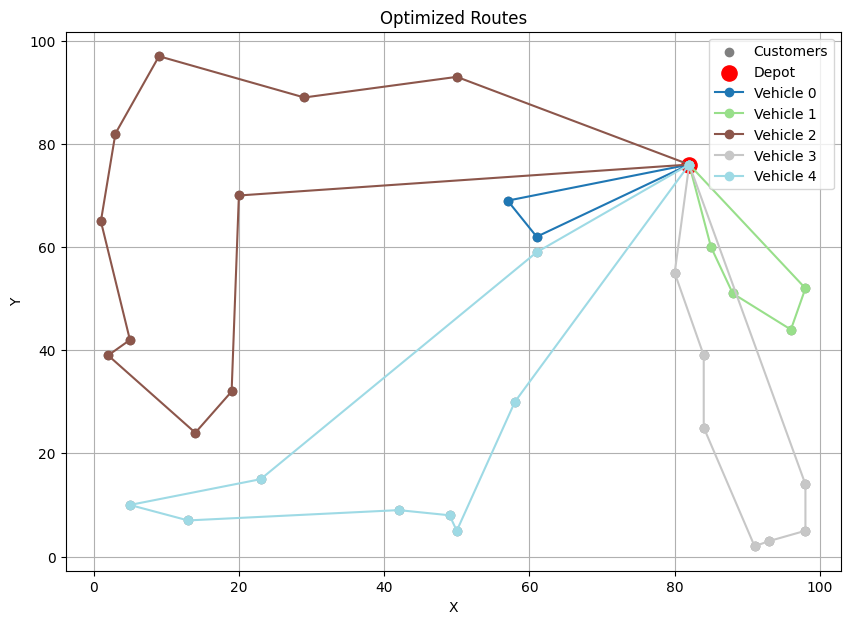

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Plot all nodes
plt.scatter(nodes_df['x'], nodes_df['y'], c='gray', label='Customers')

# Plot depot
depot_row = nodes_df.loc[node_ids[depot_index]]
plt.scatter(depot_row['x'], depot_row['y'], c='red', s=120, label='Depot')

# Colors for routes
colors = plt.cm.get_cmap('tab20', num_vehicles)

for v, r in routes.items():
    xs = []
    ys = []
    for node in r["route"]:
        xs.append(nodes_df.loc[node, 'x'])
        ys.append(nodes_df.loc[node, 'y'])

    plt.plot(xs, ys, marker='o', color=colors(v), label=f"Vehicle {v}")

plt.legend()
plt.title("Optimized Routes")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


**STEP 12 — KPI TABLE**

In [47]:
import pandas as pd

kpi_list = []

for v, r in routes.items():
    util = (r['load'] / vehicle_capacity) * 100
    nodes_served = len([n for n in r['route'] if n != node_ids[depot_index]])

    kpi_list.append({
        "vehicle": v,
        "distance": r['distance'],
        "load": r['load'],
        "utilization %": round(util, 2),
        "nodes_served": nodes_served
    })

kpi_df = pd.DataFrame(kpi_list)
display(kpi_df)


,vehicle,distance,load,utilization %,nodes_served
0,0,59,44,44.0,2
1,1,73,72,72.0,4
2,2,267,98,98.0,10
3,3,155,98,98.0,7
4,4,230,98,98.0,8


**STEP 13 — SAVE RESULTS**

In [48]:
import json

with open("/content/drive/MyDrive/Delhivery project/vrp_routes.json", "w") as f:
    json.dump(routes, f, indent=2)

kpi_df.to_csv("/content/drive/MyDrive/Delhivery project/vrp_kpis.csv", index=False)

print("Saved vrp_routes.json and vrp_kpis.csv")


Saved vrp_routes.json and vrp_kpis.csv


**What-if: change number of vehicles or capacity (quick re-run)**

To test scenarios you’ll re-create manager/routing or wrap model creation & solve into a function. Here’s a quick function pattern:

In [49]:
def solve_cvrp(num_vehicles_test, vehicle_capacity_test, time_limit_sec=30):
    # Build new manager, routing, register callbacks and dimensions (same as earlier)
    manager_test = RoutingIndexManager(num_locations, num_vehicles_test, depot_index)
    routing_test = RoutingModel(manager_test)
    # register transit callback using the same distance_matrix_int (use closure or re-create)
    def distance_cb(i,j):
        return distance_matrix_int[manager_test.IndexToNode(i)][manager_test.IndexToNode(j)]
    t_idx = routing_test.RegisterTransitCallback(distance_cb)
    routing_test.SetArcCostEvaluatorOfAllVehicles(t_idx)
    def demand_cb(i):
        return int(demands_list[manager_test.IndexToNode(i)])
    d_idx = routing_test.RegisterUnaryTransitCallback(demand_cb)
    routing_test.AddDimensionWithVehicleCapacity(d_idx, 0, [vehicle_capacity_test]*num_vehicles_test, True, "Capacity")
    search_params = __import__('ortools.constraint_solver').constraint_solver.pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.time_limit.seconds = time_limit_sec
    sol = routing_test.SolveWithParameters(search_params)
    if not sol:
        return None
    # extract basic total_distance and total_load (similar to earlier)
    total_d = 0; total_l = 0
    for vid in range(num_vehicles_test):
        idx = routing_test.Start(vid)
        while not routing_test.IsEnd(idx):
            p = idx
            idx = sol.Value(routing_test.NextVar(idx))
            total_d += routing_test.GetArcCostForVehicle(p, idx, vid)
        total_l += sol.Value(routing_test.GetDimensionOrDie("Capacity").CumulVar(idx))
    return {"num_vehicles":num_vehicles_test, "cap":vehicle_capacity_test, "total_distance":total_d, "total_load":total_l}

# Example runs
print(solve_cvrp(5,100,20))   # baseline
print(solve_cvrp(4,125,20))   # fewer vehicles but higher capacity


{'num_vehicles': 5, 'cap': 100, 'total_distance': 796, 'total_load': 410}
{'num_vehicles': 4, 'cap': 125, 'total_distance': 686, 'total_load': 410}


In [50]:
# Save data files to /content/data
nodes_df.to_csv("/content/drive/MyDrive/Delhivery project/data/nodes_df.csv", index=True)
demands_df.to_csv("/content/drive/MyDrive/Delhivery project/data/demands_df.csv", index=True)
dist_df.to_csv("/content/drive/MyDrive/Delhivery project/data/distance_matrix.csv", index=True)

print("Data files saved in /content/drive/MyDrive/Delhivery project/data/")


Data files saved in /content/drive/MyDrive/Delhivery project/data/


In [53]:
import json

# Save solution as JSON
with open("/content/drive/MyDrive/Delhivery project/output/vrp_solution.json", "w") as f:
    json.dump(routes, f, indent=2)

# Save KPIs
kpi_df.to_csv("/content/drive/MyDrive/Delhivery project/output/vrp_kpis.csv", index=False)

print("Solver outputs saved in /content/outputs/")


Solver outputs saved in /content/outputs/


In [55]:
plt.figure(figsize=(10,8))
# your plotting code...

# After plotting:
plt.savefig("/content/drive/MyDrive/Delhivery project/output/route_visual.png", dpi=300)
plt.show()

print("Route visualization saved as /content/drive/MyDrive/Delhivery project/outputs/route_visual.png")


<Figure size 1000x800 with 0 Axes>

Route visualization saved as /content/drive/MyDrive/Delhivery project/outputs/route_visual.png
